In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose


# dickey fuller test for stationarity check
from statsmodels.tsa.stattools import adfuller,acf,pacf

from statsmodels.tsa.statespace.tools import diff

# pip install pmdarima
from pmdarima.arima import auto_arima

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [2]:
office = pd.read_csv("customer_retention_office.csv")
office.head()

,reviewerID,reviewTime,main_cat,reviewText,verified,review_sentiment
0,A2NIJTYWADLK57,2017-11-07,Office Products,kids like story but while i really wanted a bo...,True,Positive
1,A2827D8EEURMP4,2017-03-07,Office Products,bought this used and it came in great conditio...,True,Positive
2,APB6087F4J09J,2016-06-25,Office Products,every story and book about corduroy is fantast...,True,Positive
3,A2DHERRZIPFU7X,2016-02-21,Office Products,i purchased this book for my first grade class...,True,Positive
4,A3JJTLTBCE7T7L,2015-01-01,Office Products,corduroy gets a pocket....riveting stuff people.,True,Neutral


In [68]:
office.review_sentiment.value_counts()

Positive    417584
Neutral      59973
Negative     37124
Name: review_sentiment, dtype: int64

In [69]:
office = office[office.verified == 1]
office

,reviewerID,reviewTime,main_cat,reviewText,verified,review_sentiment
0,A2NIJTYWADLK57,2017-11-07,Office Products,kids like story but while i really wanted a bo...,True,Positive
1,A2827D8EEURMP4,2017-03-07,Office Products,bought this used and it came in great conditio...,True,Positive
2,APB6087F4J09J,2016-06-25,Office Products,every story and book about corduroy is fantast...,True,Positive
3,A2DHERRZIPFU7X,2016-02-21,Office Products,i purchased this book for my first grade class...,True,Positive
4,A3JJTLTBCE7T7L,2015-01-01,Office Products,corduroy gets a pocket....riveting stuff people.,True,Neutral
...,...,...,...,...,...,...
514676,A1J3T2AHYBSRBI,2009-09-17,Office Products,"i am sure i am biased, as i have been in love ...",True,Positive
514677,A3QSM5XHPL1T6Y,2009-09-15,Office Products,there's been a lot of discussion and not a lit...,True,Positive
514678,A1TH7MZ6NDUAU8,2017-11-04,Office Products,great album!!!,True,Positive
514679,APXK8A63WY91A,2018-02-08,Office Products,childrens song cd,True,Neutral


In [70]:
office2 = office[office.reviewTime >= '2015-01-01']

In [71]:
office2

,reviewerID,reviewTime,main_cat,reviewText,verified,review_sentiment
0,A2NIJTYWADLK57,2017-11-07,Office Products,kids like story but while i really wanted a bo...,True,Positive
1,A2827D8EEURMP4,2017-03-07,Office Products,bought this used and it came in great conditio...,True,Positive
2,APB6087F4J09J,2016-06-25,Office Products,every story and book about corduroy is fantast...,True,Positive
3,A2DHERRZIPFU7X,2016-02-21,Office Products,i purchased this book for my first grade class...,True,Positive
4,A3JJTLTBCE7T7L,2015-01-01,Office Products,corduroy gets a pocket....riveting stuff people.,True,Neutral
...,...,...,...,...,...,...
514662,A3SANANXTCBSHT,2017-02-15,Office Products,fun cd,True,Positive
514663,A24J4WERTPWAH3,2015-02-05,Office Products,grandson-2-loves it.,True,Neutral
514678,A1TH7MZ6NDUAU8,2017-11-04,Office Products,great album!!!,True,Positive
514679,APXK8A63WY91A,2018-02-08,Office Products,childrens song cd,True,Neutral


In [7]:
a = pd.pivot_table(data = office2, index = 'reviewTime' ,values = "main_cat", columns = "review_sentiment", aggfunc = "count")
a.reset_index(inplace = True)
a

review_sentiment,reviewTime,Negative,Neutral,Positive
0,2015-01-01,33.0,43.0,255.0
1,2015-01-02,21.0,62.0,266.0
2,2015-01-03,29.0,48.0,317.0
3,2015-01-04,20.0,50.0,292.0
4,2015-01-05,20.0,54.0,267.0
...,...,...,...,...
1365,2018-09-27,NaN,1.0,3.0
1366,2018-09-28,NaN,NaN,3.0
1367,2018-09-29,1.0,1.0,3.0
1368,2018-09-30,1.0,NaN,4.0


In [8]:
a['reviewTime'] = pd.to_datetime(a['reviewTime'])

In [9]:
b = a.groupby(a.reviewTime.dt.strftime('%b %Y'))['Negative','Positive','Neutral'].sum()  # count of asin provides the number of products ordered in particular month
b = pd.DataFrame(b)
b.reset_index(inplace=True)

b['reviewTime'] = pd.to_datetime(b['reviewTime'])
b = b.sort_values('reviewTime')
#b.set_index('reviewTime',inplace = True)
b.reset_index(inplace = True)
b.drop('index', axis = 1, inplace = True)
b

review_sentiment,reviewTime,Negative,Positive,Neutral
0,2015-01-01,618.0,7945.0,1205.0
1,2015-02-01,625.0,8100.0,1337.0
2,2015-03-01,658.0,8519.0,1314.0
3,2015-04-01,620.0,7039.0,1220.0
4,2015-05-01,575.0,7126.0,1121.0
5,2015-06-01,637.0,7256.0,1181.0
6,2015-07-01,635.0,7593.0,1206.0
7,2015-08-01,678.0,8241.0,1416.0
8,2015-09-01,673.0,8314.0,1415.0
9,2015-10-01,770.0,8675.0,1281.0


In [10]:
b['review_count'] = b.Negative + b.Positive + b.Neutral
b

review_sentiment,reviewTime,Negative,Positive,Neutral,review_count
0,2015-01-01,618.0,7945.0,1205.0,9768.0
1,2015-02-01,625.0,8100.0,1337.0,10062.0
2,2015-03-01,658.0,8519.0,1314.0,10491.0
3,2015-04-01,620.0,7039.0,1220.0,8879.0
4,2015-05-01,575.0,7126.0,1121.0,8822.0
5,2015-06-01,637.0,7256.0,1181.0,9074.0
6,2015-07-01,635.0,7593.0,1206.0,9434.0
7,2015-08-01,678.0,8241.0,1416.0,10335.0
8,2015-09-01,673.0,8314.0,1415.0,10402.0
9,2015-10-01,770.0,8675.0,1281.0,10726.0


## Number of Negative, Positive and Neutral Reviews denotes sale of the product in a given time frame ( which is 1 month )

In [11]:
pos = b[['reviewTime','Positive']]
pos.set_index('reviewTime',inplace = True)
#pos = pos[:len(pos)-1]
pos

review_sentiment,Positive
reviewTime,
2015-01-01,7945.0
2015-02-01,8100.0
2015-03-01,8519.0
2015-04-01,7039.0
2015-05-01,7126.0
2015-06-01,7256.0
2015-07-01,7593.0
2015-08-01,8241.0
2015-09-01,8314.0


In [12]:
pos_df = pos.resample('M')['Positive'].sum()  # resampling data Quarterly 
print(pos_df)

reviewTime
2015-01-31    7945.0
2015-02-28    8100.0
2015-03-31    8519.0
2015-04-30    7039.0
2015-05-31    7126.0
2015-06-30    7256.0
2015-07-31    7593.0
2015-08-31    8241.0
2015-09-30    8314.0
2015-10-31    8675.0
2015-11-30    8364.0
2015-12-31    8204.0
2016-01-31    9862.0
2016-02-29    9698.0
2016-03-31    9455.0
2016-04-30    8343.0
2016-05-31    9115.0
2016-06-30    8692.0
2016-07-31    8885.0
2016-08-31    9731.0
2016-09-30    9048.0
2016-10-31    8777.0
2016-11-30    7704.0
2016-12-31    9541.0
2017-01-31    9839.0
2017-02-28    8031.0
2017-03-31    8486.0
2017-04-30    7361.0
2017-05-31    6233.0
2017-06-30    5843.0
2017-07-31    5869.0
2017-08-31    6663.0
2017-09-30    5940.0
2017-10-31    5558.0
2017-11-30    5003.0
2017-12-31    4946.0
2018-01-31    6185.0
2018-02-28    5654.0
2018-03-31    6718.0
2018-04-30    6124.0
2018-05-31    4331.0
2018-06-30    2344.0
2018-07-31    1607.0
2018-08-31     896.0
2018-09-30     281.0
2018-10-31       4.0
Freq: M, Name: Positive

In [13]:
pos_df[:]

reviewTime
2015-01-31    7945.0
2015-02-28    8100.0
2015-03-31    8519.0
2015-04-30    7039.0
2015-05-31    7126.0
2015-06-30    7256.0
2015-07-31    7593.0
2015-08-31    8241.0
2015-09-30    8314.0
2015-10-31    8675.0
2015-11-30    8364.0
2015-12-31    8204.0
2016-01-31    9862.0
2016-02-29    9698.0
2016-03-31    9455.0
2016-04-30    8343.0
2016-05-31    9115.0
2016-06-30    8692.0
2016-07-31    8885.0
2016-08-31    9731.0
2016-09-30    9048.0
2016-10-31    8777.0
2016-11-30    7704.0
2016-12-31    9541.0
2017-01-31    9839.0
2017-02-28    8031.0
2017-03-31    8486.0
2017-04-30    7361.0
2017-05-31    6233.0
2017-06-30    5843.0
2017-07-31    5869.0
2017-08-31    6663.0
2017-09-30    5940.0
2017-10-31    5558.0
2017-11-30    5003.0
2017-12-31    4946.0
2018-01-31    6185.0
2018-02-28    5654.0
2018-03-31    6718.0
2018-04-30    6124.0
2018-05-31    4331.0
2018-06-30    2344.0
2018-07-31    1607.0
2018-08-31     896.0
2018-09-30     281.0
2018-10-31       4.0
Freq: M, Name: Positive

In [14]:
pos_df = pos_df[:-7]
pos_df

reviewTime
2015-01-31    7945.0
2015-02-28    8100.0
2015-03-31    8519.0
2015-04-30    7039.0
2015-05-31    7126.0
2015-06-30    7256.0
2015-07-31    7593.0
2015-08-31    8241.0
2015-09-30    8314.0
2015-10-31    8675.0
2015-11-30    8364.0
2015-12-31    8204.0
2016-01-31    9862.0
2016-02-29    9698.0
2016-03-31    9455.0
2016-04-30    8343.0
2016-05-31    9115.0
2016-06-30    8692.0
2016-07-31    8885.0
2016-08-31    9731.0
2016-09-30    9048.0
2016-10-31    8777.0
2016-11-30    7704.0
2016-12-31    9541.0
2017-01-31    9839.0
2017-02-28    8031.0
2017-03-31    8486.0
2017-04-30    7361.0
2017-05-31    6233.0
2017-06-30    5843.0
2017-07-31    5869.0
2017-08-31    6663.0
2017-09-30    5940.0
2017-10-31    5558.0
2017-11-30    5003.0
2017-12-31    4946.0
2018-01-31    6185.0
2018-02-28    5654.0
2018-03-31    6718.0
Freq: M, Name: Positive, dtype: float64

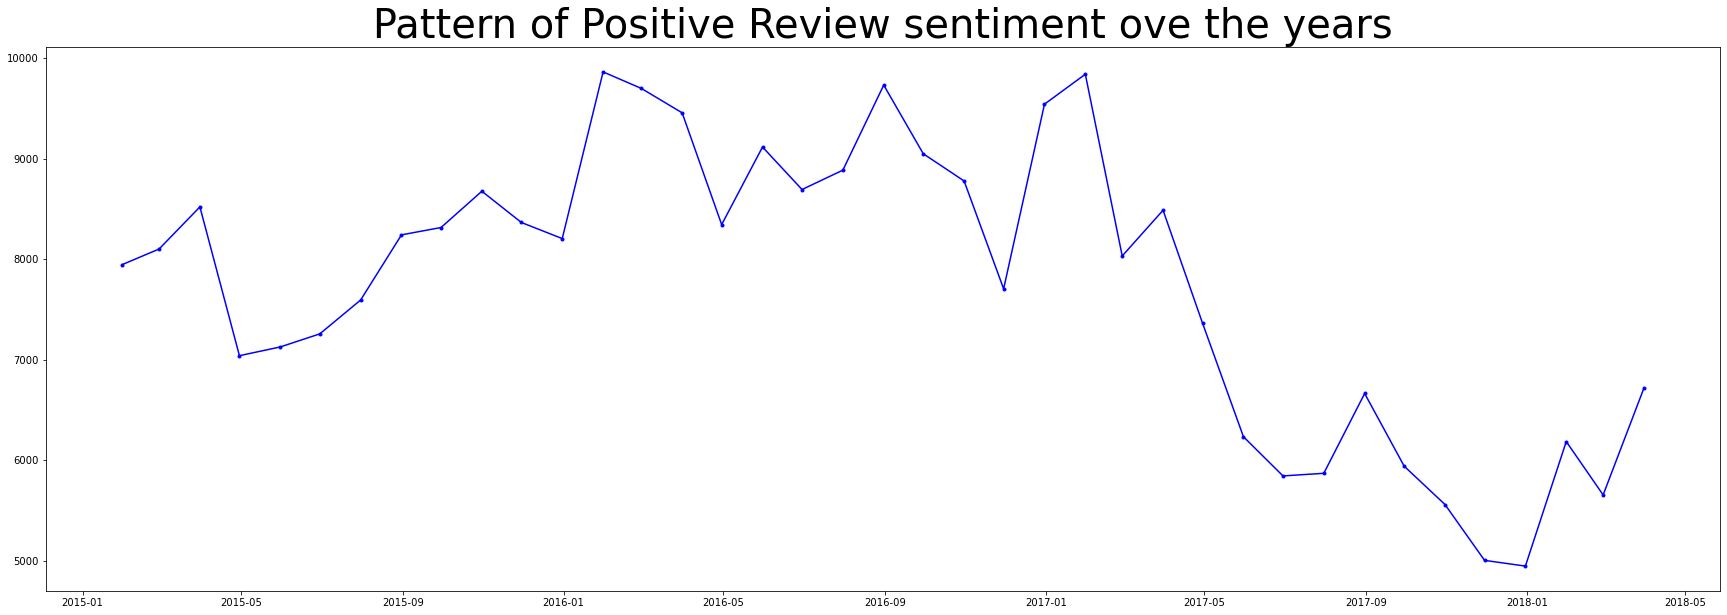

In [15]:
plt.figure(figsize=(30,10))
plt.title("Pattern of Positive Review sentiment ove the years", size = 40)
plt.plot(pos_df, color = 'b', marker = '.')
plt.show()

## Decomposition to check the trend and seasonality in the data

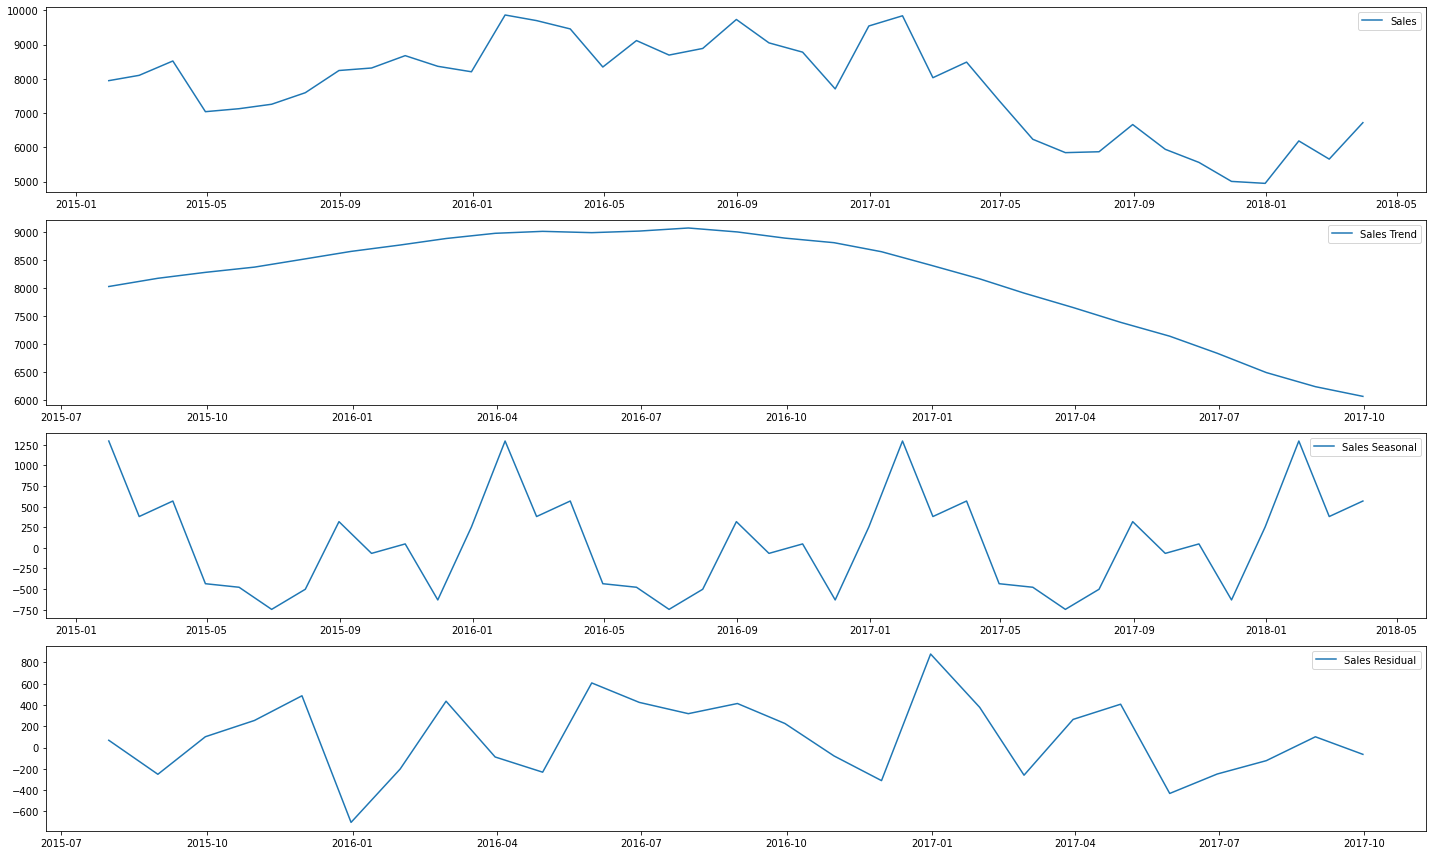

In [16]:
decomposition = seasonal_decompose(pos_df, period = 12)
decomposition
d_trend = decomposition.trend 
d_seasonal = decomposition.seasonal
d_residual = decomposition.resid

fig,ax = plt.subplots(4,1,figsize=(20,12))

plt.subplot(411)
plt.plot(pos_df,label='Sales')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(d_trend,label='Sales Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(d_seasonal,label='Sales Seasonal')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(d_residual,label='Sales Residual')
plt.legend(loc='best')

plt.tight_layout()

In [17]:
def checkStationarity(data):
    pvalue = adfuller(data)[1]
    print(pvalue)
    if pvalue < 0.05:
        ret = "Data is Stationary. Proceed to model building"
    else:
        ret = "Data is not Stationary. Make is stationary"
        
    return(ret)

In [18]:
checkStationarity(pos_df)

0.25601184521328635


'Data is not Stationary. Make is stationary'

In [19]:
diff_pos_df = pos_df - pos_df.shift(1)
diff_pos_df.dropna(inplace=True)
checkStationarity(diff_pos_df)

3.9622824367912183e-10


'Data is Stationary. Proceed to model building'

d = 1

# Since the data is stationary the value of d for modelling is should be 0  

In [20]:
# split the data into train and test
length = int(0.8 * len(pos_df))
train1 = pos_df.iloc[:length]
test1 = pos_df.iloc[length:]
print("train = {}, test = {}".format(len(train1), len(test1)))

train = 31, test = 8


In [21]:
train1

reviewTime
2015-01-31    7945.0
2015-02-28    8100.0
2015-03-31    8519.0
2015-04-30    7039.0
2015-05-31    7126.0
2015-06-30    7256.0
2015-07-31    7593.0
2015-08-31    8241.0
2015-09-30    8314.0
2015-10-31    8675.0
2015-11-30    8364.0
2015-12-31    8204.0
2016-01-31    9862.0
2016-02-29    9698.0
2016-03-31    9455.0
2016-04-30    8343.0
2016-05-31    9115.0
2016-06-30    8692.0
2016-07-31    8885.0
2016-08-31    9731.0
2016-09-30    9048.0
2016-10-31    8777.0
2016-11-30    7704.0
2016-12-31    9541.0
2017-01-31    9839.0
2017-02-28    8031.0
2017-03-31    8486.0
2017-04-30    7361.0
2017-05-31    6233.0
2017-06-30    5843.0
2017-07-31    5869.0
Freq: M, Name: Positive, dtype: float64

In [22]:
test1

reviewTime
2017-08-31    6663.0
2017-09-30    5940.0
2017-10-31    5558.0
2017-11-30    5003.0
2017-12-31    4946.0
2018-01-31    6185.0
2018-02-28    5654.0
2018-03-31    6718.0
Freq: M, Name: Positive, dtype: float64

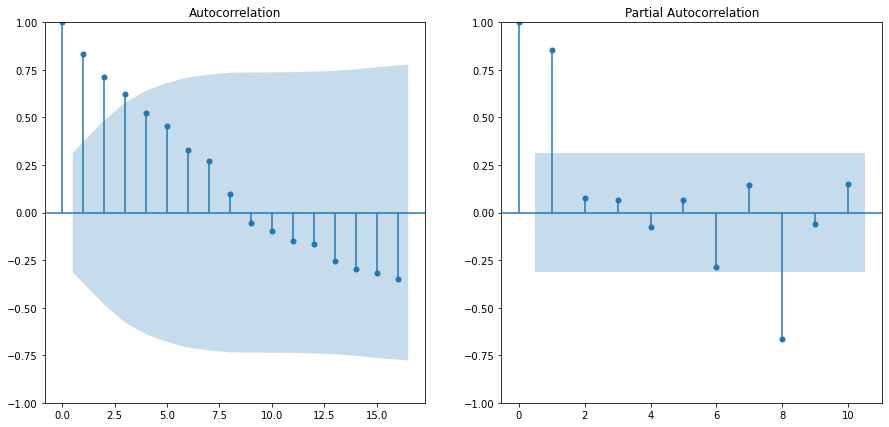

In [23]:
fig,ax=plt.subplots(1,2,figsize=(15,7))
plot_acf(pos_df, ax=ax[0]) # for q
plot_pacf(pos_df, lags = 10 , ax=ax[1]) # for p
plt.show()

In [24]:
d = 1; # as the data is stationary 
lis=[]
for p in range(3):
    for q in range(4):
        lis.append((p,d,q))

# building model
model=[]
for i in lis:
    m = ARIMA(train1, order=i).fit() 
    model.append(m)

# checking model is good or not
c=1
for i in model:
    pvalue = sm.stats.acorr_ljungbox(i.resid, lags=[1], return_df=True)['lb_pvalue'].values
    if pvalue < 0.05:
        print(f'Model {c} Not a good model')
    else:
        print(f'Model {c} Good model')
    c+=1

Model 1 Good model
Model 2 Good model
Model 3 Good model
Model 4 Good model
Model 5 Good model
Model 6 Good model
Model 7 Good model
Model 8 Good model
Model 9 Good model
Model 10 Good model
Model 11 Good model
Model 12 Good model


In [25]:
# calculating AIC and BIC score   
aic=[]
bic=[]
for i in model[0:]:
    aic.append(i.aic)
    bic.append(i.bic)

# predicting values
forecast=[]
for i in model[0:]:
    fcast1 = i.predict(start=len(train1), end=len(train1)+len(test1)-1)
    forecast.append(fcast1)

# calculating MSE and RMSE score
MSE = []
RMSE = []
for i in forecast:
    mse = mean_squared_error(test1, i)
    rmse = np.sqrt(mse)
    MSE.append(mse)
    RMSE.append(rmse)

# printing model numbers
model_no=[]
for i in range(0,len(model)):
    model_no.append('Model '+str(i))
    
# dataframe of all results
df_results = pd.DataFrame({'Model No.': model_no, '(p, d, q)':lis[0:], 'AIC': aic, 'BIC': bic, 'MSE': MSE, 'RMSE': RMSE})
df_results

,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
0,Model 0,"(0, 1, 0)",489.626891,491.028089,400120.625000,632.550887
1,Model 1,"(0, 1, 1)",491.143245,493.945639,400404.001446,632.774843
2,Model 2,"(0, 1, 2)",492.882057,497.085649,415560.195561,644.639586
3,Model 3,"(0, 1, 3)",494.160132,499.764922,589460.274774,767.763163
4,Model 4,"(1, 1, 0)",491.201436,494.003831,400006.336355,632.460541
5,Model 5,"(1, 1, 1)",492.716405,496.919997,480702.392418,693.327046
6,Model 6,"(1, 1, 2)",494.663011,500.267800,486426.877506,697.443100
7,Model 7,"(1, 1, 3)",496.107490,503.113477,557410.312326,746.599164
8,Model 8,"(2, 1, 0)",493.099220,497.302812,400581.465255,632.915054
9,Model 9,"(2, 1, 1)",494.645257,500.250047,486464.151428,697.469821


In [26]:
print('Taking model with lowest RMSE score:')
df_results[df_results.RMSE==df_results.RMSE.min()]

Taking model with lowest RMSE score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
4,Model 4,"(1, 1, 0)",491.201436,494.003831,400006.336355,632.460541


In [27]:
p=1 ; q=0; d=1
P=1; Q=1
m1 = sm.tsa.statespace.SARIMAX(train1,order=(p,d,q),seasonal_order=(P,d,Q,15)).fit()

In [28]:
start = len(train1) 
end = len(train1)+len(test1)-1
print(start)
print(end)
f1 = m1.predict(start,end)
dfres1=pd.DataFrame({'actual':test1, 'forecast':f1.values})
dfres1['error'] = dfres1.actual - dfres1.forecast

print(dfres1)
# Calcualate the MSE
mse1 = mean_squared_error(dfres1.actual, dfres1.forecast) #on test data
print('mean squared error =',mse1)
rmse1 = np.sqrt(mse1)
print('root mean squared error =',rmse1)

31
38
            actual     forecast        error
reviewTime                                  
2017-08-31  6663.0  6420.202498   242.797502
2017-09-30  5940.0  6316.751484  -376.751484
2017-10-31  5558.0  5953.822113  -395.822113
2017-11-30  5003.0  6414.263539 -1411.263539
2017-12-31  4946.0  6103.395134 -1157.395134
2018-01-31  6185.0  6065.437332   119.562668
2018-02-28  5654.0  5718.102418   -64.102418
2018-03-31  6718.0  6705.021427    12.978573
mean squared error = 463421.06513585453
root mean squared error = 680.7503691779054


Text(0.5, 1.0, 'ARIMA model')

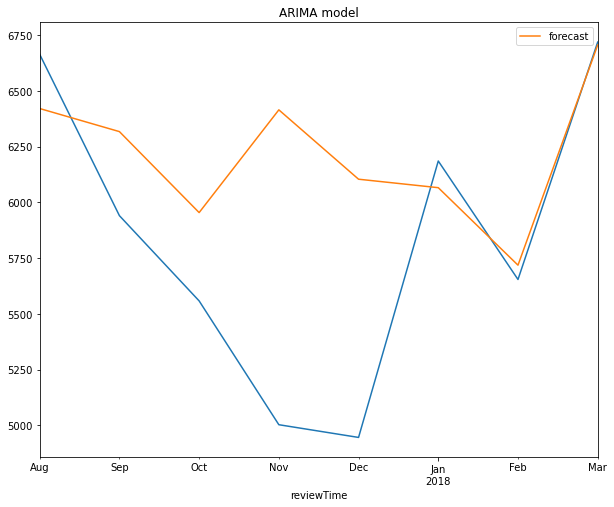

In [29]:
# plot the actual and forecast data of the test data
dfres1.actual.plot(figsize=(10,8))
dfres1.forecast.plot(legend=True)
plt.title("ARIMA model")

In [30]:
# make future predictions
n_steps = 12 # number of steps to forecast (3 years with monthly data)
start_index = len(pos_df) - 1
end_index = start_index + n_steps
future_predictions1 = m1.predict(start=start_index, end=end_index)
future_predictions1

2018-03-31    6705.021427
2018-04-30    6974.210277
2018-05-31    5933.262456
2018-06-30    6116.676310
2018-07-31    6050.827478
2018-08-31    5412.189374
2018-09-30    5071.925630
2018-10-31    5764.762425
2018-11-30    6216.045502
2018-12-31    6177.194483
2019-01-31    5714.655858
2019-02-28    6106.869646
2019-03-31    5861.966020
Freq: M, Name: predicted_mean, dtype: float64

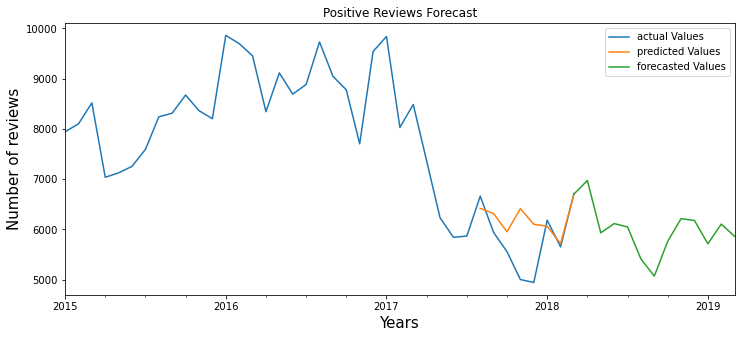

In [31]:
pos_df.plot(figsize=(12,5),label  = "actual Values")

dfres1.forecast.plot(figsize=(12,5),label  = "predicted Values")
future_predictions1.plot(figsize=(12,5),label  = "forecasted Values")

plt.title("Positive Reviews Forecast")
plt.ylabel("Number of reviews", size = 15)

plt.xlabel("Years", size = 15)


plt.legend()
plt.show()

In [32]:
neg_df = b[['reviewTime','Negative']]
neg_df.set_index('reviewTime',inplace = True)
#neg_df = neg_df[:len(neg_df)-1]
neg_df

review_sentiment,Negative
reviewTime,
2015-01-01,618.0
2015-02-01,625.0
2015-03-01,658.0
2015-04-01,620.0
2015-05-01,575.0
2015-06-01,637.0
2015-07-01,635.0
2015-08-01,678.0
2015-09-01,673.0


In [33]:
neg_df = neg_df.resample('M')['Negative'].sum()  # resampling data Quarterly 
neg_df

reviewTime
2015-01-31    618.0
2015-02-28    625.0
2015-03-31    658.0
2015-04-30    620.0
2015-05-31    575.0
2015-06-30    637.0
2015-07-31    635.0
2015-08-31    678.0
2015-09-30    673.0
2015-10-31    770.0
2015-11-30    656.0
2015-12-31    733.0
2016-01-31    786.0
2016-02-29    748.0
2016-03-31    677.0
2016-04-30    707.0
2016-05-31    681.0
2016-06-30    657.0
2016-07-31    748.0
2016-08-31    710.0
2016-09-30    753.0
2016-10-31    677.0
2016-11-30    641.0
2016-12-31    779.0
2017-01-31    725.0
2017-02-28    679.0
2017-03-31    713.0
2017-04-30    575.0
2017-05-31    562.0
2017-06-30    503.0
2017-07-31    523.0
2017-08-31    545.0
2017-09-30    555.0
2017-10-31    547.0
2017-11-30    494.0
2017-12-31    473.0
2018-01-31    565.0
2018-02-28    531.0
2018-03-31    596.0
2018-04-30    546.0
2018-05-31    393.0
2018-06-30    208.0
2018-07-31    144.0
2018-08-31     90.0
2018-09-30     24.0
2018-10-31      0.0
Freq: M, Name: Negative, dtype: float64

In [34]:
neg_df = neg_df[:-6]
neg_df

reviewTime
2015-01-31    618.0
2015-02-28    625.0
2015-03-31    658.0
2015-04-30    620.0
2015-05-31    575.0
2015-06-30    637.0
2015-07-31    635.0
2015-08-31    678.0
2015-09-30    673.0
2015-10-31    770.0
2015-11-30    656.0
2015-12-31    733.0
2016-01-31    786.0
2016-02-29    748.0
2016-03-31    677.0
2016-04-30    707.0
2016-05-31    681.0
2016-06-30    657.0
2016-07-31    748.0
2016-08-31    710.0
2016-09-30    753.0
2016-10-31    677.0
2016-11-30    641.0
2016-12-31    779.0
2017-01-31    725.0
2017-02-28    679.0
2017-03-31    713.0
2017-04-30    575.0
2017-05-31    562.0
2017-06-30    503.0
2017-07-31    523.0
2017-08-31    545.0
2017-09-30    555.0
2017-10-31    547.0
2017-11-30    494.0
2017-12-31    473.0
2018-01-31    565.0
2018-02-28    531.0
2018-03-31    596.0
2018-04-30    546.0
Freq: M, Name: Negative, dtype: float64

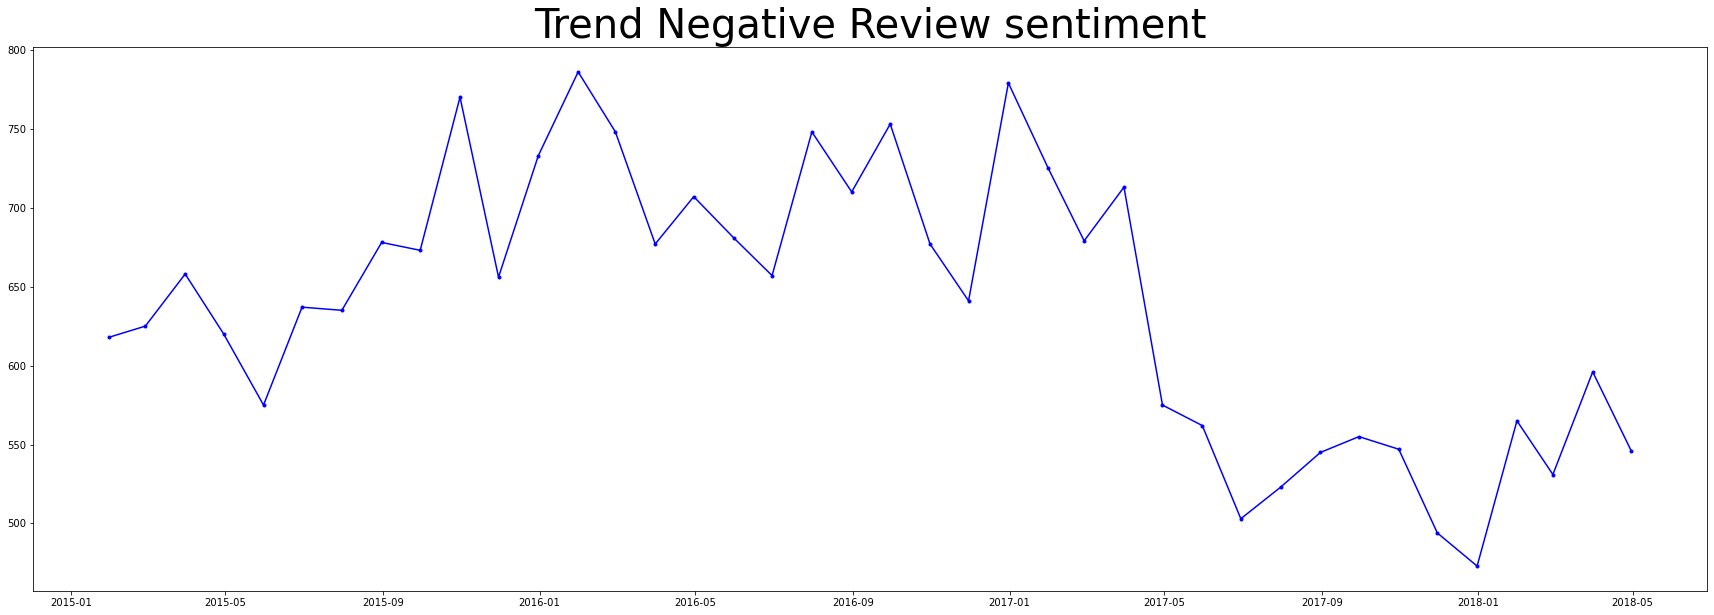

In [35]:
plt.figure(figsize=(30,10))
plt.title("Trend Negative Review sentiment", size = 40)
plt.plot(neg_df, color = 'b', marker = '.')
plt.show()

# Checking for stationarity

In [36]:
checkStationarity(neg_df)

0.592242811083951


'Data is not Stationary. Make is stationary'

In [37]:
diff_neg_df = neg_df - neg_df.shift(1)
diff_neg_df.dropna(inplace=True)
checkStationarity(diff_neg_df)

1.3292425089053069e-14


'Data is Stationary. Proceed to model building'

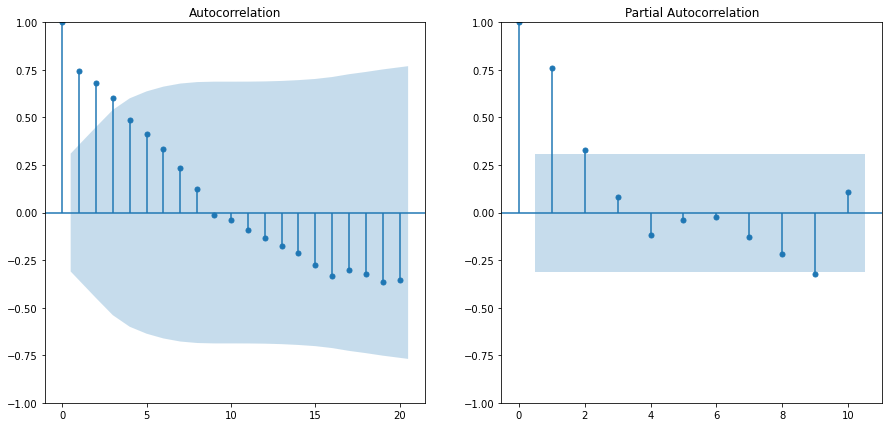

In [38]:
fig,ax=plt.subplots(1,2,figsize=(15,7))
plot_acf(neg_df, lags = 20, ax=ax[0]) # for q
plot_pacf(neg_df, lags = 10, ax=ax[1]) # for p
plt.show()

In [39]:
# split the data into train and test
length = int(0.8 * len(neg_df))
train2 = neg_df.iloc[:length]
test2 = neg_df.iloc[length:]
print("train = {}, test = {}".format(len(train2), len(test2)))

train = 32, test = 8


In [40]:
d = 1; 
lis=[]
for p in range(2):
    for q in range(4):
        lis.append((p,d,q))

# building model
model=[]
for i in lis:
    m = ARIMA(train2, order=i).fit() 
    model.append(m)

# checking model is good or not
c=1
for i in model:
    pvalue = sm.stats.acorr_ljungbox(i.resid, lags=[1], return_df=True)['lb_pvalue'].values
    if pvalue < 0.05:
        print(f'Model {c} Not a good model')
    else:
        print(f'Model {c} Good model')
    c+=1

Model 1 Good model
Model 2 Good model
Model 3 Good model
Model 4 Good model
Model 5 Good model
Model 6 Good model
Model 7 Good model
Model 8 Good model


In [41]:
# calculating AIC and BIC score   
aic=[]
bic=[]
for i in model[0:]:
    aic.append(i.aic)
    bic.append(i.bic)

# predicting values
forecast=[]
for i in model[0:]:
    fcast2 = i.predict(start=len(train2), end=len(train2)+len(test2)-1)
    forecast.append(fcast2)

# calculating MSE and RMSE score
MSE = []
RMSE = []
for i in forecast:
    mse = mean_squared_error(test2, i)
    rmse = np.sqrt(mse)
    MSE.append(mse)
    RMSE.append(rmse)

# printing model numbers
model_no=[]
for i in range(0,len(model)):
    model_no.append('Model '+str(i))
    
# dataframe of all results
df_results = pd.DataFrame({'Model No.': model_no, '(p, d, q)':lis[0:], 'AIC': aic, 'BIC': bic, 'MSE': MSE, 'RMSE': RMSE})
df_results

,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
0,Model 0,"(0, 1, 0)",345.437732,346.871719,1385.875000,37.227342
1,Model 1,"(0, 1, 1)",342.665528,345.533503,1341.985014,36.633114
2,Model 2,"(0, 1, 2)",344.576618,348.878580,1353.247112,36.786507
3,Model 3,"(0, 1, 3)",346.485778,352.221727,1403.194337,37.459236
4,Model 4,"(1, 1, 0)",343.203978,346.071953,1348.830833,36.726432
5,Model 5,"(1, 1, 1)",344.606306,348.908268,1346.658397,36.696845
6,Model 6,"(1, 1, 2)",346.563164,352.299113,1359.350243,36.869367
7,Model 7,"(1, 1, 3)",347.671221,354.841157,1405.313414,37.487510


In [42]:
print('Taking model with lowest RMSE score:')
df_results[df_results.RMSE==df_results.RMSE.min()]

Taking model with lowest RMSE score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
1,Model 1,"(0, 1, 1)",342.665528,345.533503,1341.985014,36.633114


In [43]:
p=0 ; q=1; d=1
P=1; Q=1
m2 = sm.tsa.statespace.SARIMAX(train2,order=(p,d,q),seasonal_order=(P,d,Q,18)).fit()

In [44]:
start = len(train2) 

end = len(train2)+len(test2)-1 
print(start)
print(end)
f2 = m2.predict(start,end)
dfres2=pd.DataFrame({'actual':test2, 'forecast':f2.values})
dfres2['error'] = dfres2.actual - dfres2.forecast
print(dfres2)
# Calcualate the MSE
mse2 = mean_squared_error(dfres2.actual, dfres2.forecast) #on test data
print('mean squared error =',mse2)
rmse2 = np.sqrt(mse2)
print('root mean squared error =',rmse2)

32
39
            actual    forecast      error
reviewTime                               
2017-09-30   555.0  463.367890  91.632110
2017-10-31   547.0  492.938700  54.061300
2017-11-30   494.0  467.144697  26.855303
2017-12-31   473.0  442.283518  30.716482
2018-01-31   565.0  525.660150  39.339850
2018-02-28   531.0  530.649881   0.350119
2018-03-31   596.0  564.080065  31.919935
2018-04-30   546.0  524.387805  21.612195
mean squared error = 2002.1866407304324
root mean squared error = 44.74580025801787


Text(0.5, 1.0, 'ARIMA model')

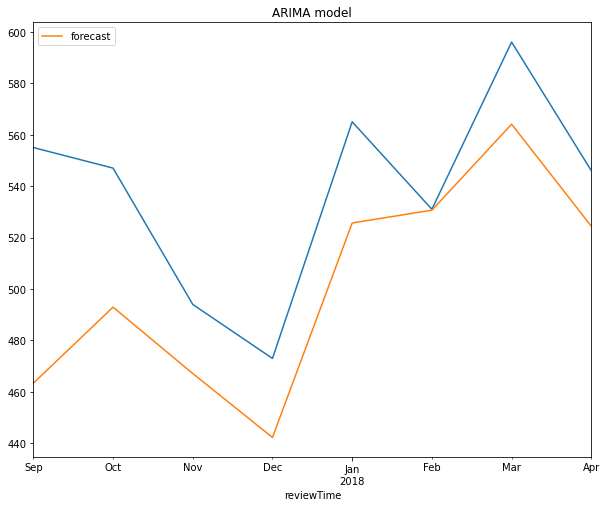

In [45]:
# plot the actual and forecast data of the test data
dfres2.actual.plot(figsize=(10,8))
dfres2.forecast.plot(legend=True)
plt.title("ARIMA model")

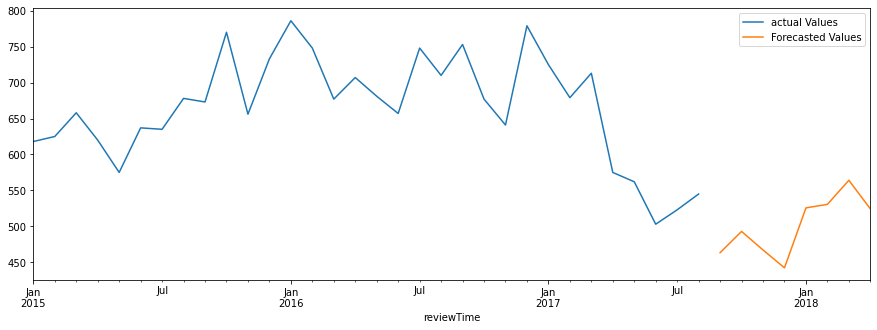

In [46]:
train2.plot(figsize=(15,5),label  = "actual Values")
dfres2.forecast.plot(label = "Forecasted Values")
plt.legend()
plt.show()

In [47]:
# make future predictions
n_steps = 12 # number of steps to forecast (2 years with monthly data)
start_index = len(neg_df) - 1
end_index = start_index + n_steps
future_predictions2 = m2.predict(start=start_index, end=end_index)
future_predictions2

2018-04-30    524.387805
2018-05-31    479.809613
2018-06-30    545.192671
2018-07-31    540.868134
2018-08-31    579.862140
2018-09-30    576.599987
2018-10-31    663.032337
2018-11-30    553.582990
2018-12-31    624.460578
2019-01-31    675.961995
2019-02-28    640.659918
2019-03-31    569.208278
2019-04-30    599.171886
Freq: M, Name: predicted_mean, dtype: float64

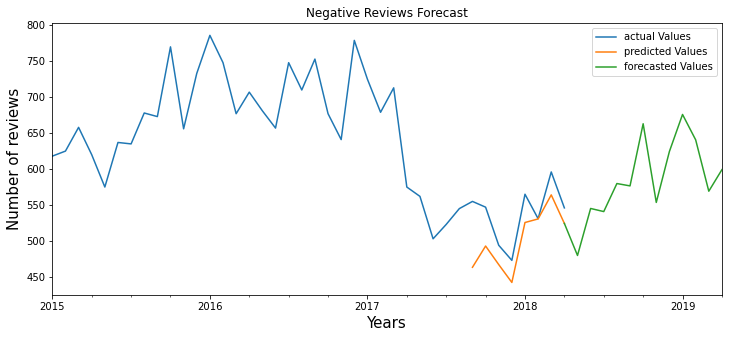

In [48]:
neg_df.plot(figsize=(12,5),label  = "actual Values")

dfres2.forecast.plot(figsize=(12,5),label  = "predicted Values")
future_predictions2.plot(figsize=(12,5),label  = "forecasted Values")

plt.title("Negative Reviews Forecast")
plt.ylabel("Number of reviews", size = 15)

plt.xlabel("Years", size = 15)
plt.legend()
plt.show()

In [49]:
b

review_sentiment,reviewTime,Negative,Positive,Neutral,review_count
0,2015-01-01,618.0,7945.0,1205.0,9768.0
1,2015-02-01,625.0,8100.0,1337.0,10062.0
2,2015-03-01,658.0,8519.0,1314.0,10491.0
3,2015-04-01,620.0,7039.0,1220.0,8879.0
4,2015-05-01,575.0,7126.0,1121.0,8822.0
5,2015-06-01,637.0,7256.0,1181.0,9074.0
6,2015-07-01,635.0,7593.0,1206.0,9434.0
7,2015-08-01,678.0,8241.0,1416.0,10335.0
8,2015-09-01,673.0,8314.0,1415.0,10402.0
9,2015-10-01,770.0,8675.0,1281.0,10726.0


In [50]:
neu_df = b[['reviewTime','Neutral']]
neu_df.set_index('reviewTime',inplace = True)
#neu_df = neu_df[:len(neu_df)-1]
neu_df.head()

review_sentiment,Neutral
reviewTime,
2015-01-01,1205.0
2015-02-01,1337.0
2015-03-01,1314.0
2015-04-01,1220.0
2015-05-01,1121.0


In [51]:
neu_df = neu_df.resample('M')['Neutral'].sum()  # resampling data Quarterly 
neu_df


reviewTime
2015-01-31    1205.0
2015-02-28    1337.0
2015-03-31    1314.0
2015-04-30    1220.0
2015-05-31    1121.0
2015-06-30    1181.0
2015-07-31    1206.0
2015-08-31    1416.0
2015-09-30    1415.0
2015-10-31    1281.0
2015-11-30    1261.0
2015-12-31    1223.0
2016-01-31    1466.0
2016-02-29    1409.0
2016-03-31    1407.0
2016-04-30    1357.0
2016-05-31    1481.0
2016-06-30    1258.0
2016-07-31    1362.0
2016-08-31    1424.0
2016-09-30    1497.0
2016-10-31    1384.0
2016-11-30    1336.0
2016-12-31    1565.0
2017-01-31    1637.0
2017-02-28    1313.0
2017-03-31    1561.0
2017-04-30    1172.0
2017-05-31     945.0
2017-06-30     997.0
2017-07-31     996.0
2017-08-31    1042.0
2017-09-30    1054.0
2017-10-31     974.0
2017-11-30     905.0
2017-12-31     835.0
2018-01-31    1063.0
2018-02-28     989.0
2018-03-31    1165.0
2018-04-30    1161.0
2018-05-31     807.0
2018-06-30     414.0
2018-07-31     257.0
2018-08-31     141.0
2018-09-30      37.0
2018-10-31       0.0
Freq: M, Name: Neutral,

In [52]:
neu_df = neu_df[:-6] 

In [53]:
checkStationarity(neu_df)

0.1544438346582236


'Data is not Stationary. Make is stationary'

In [54]:
diff_neu_df = neu_df - neu_df.shift(1)
diff_neu_df.dropna(inplace=True)
checkStationarity(diff_neu_df)

2.7137123490478867e-12


'Data is Stationary. Proceed to model building'

In [55]:
# split the data into train and test
length = int(0.8 * len(neu_df))
train3 = neu_df.iloc[:length]
test3 = neu_df.iloc[length:]
print("train = {}, test = {}".format(len(train3), len(test3)))

train = 32, test = 8


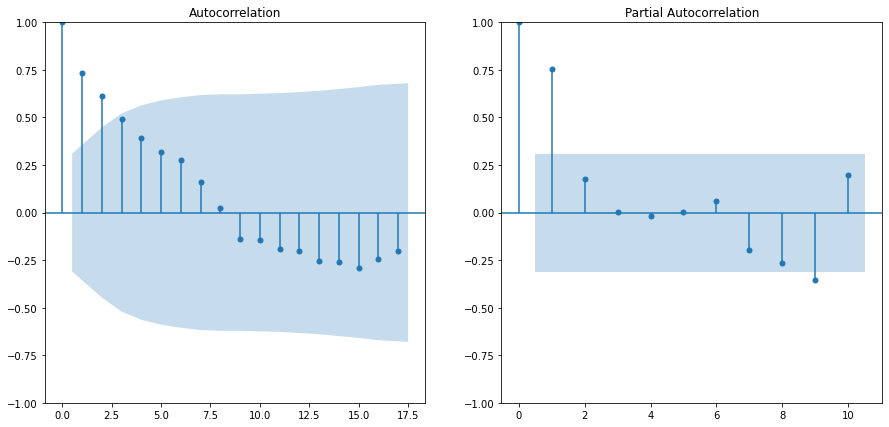

In [56]:
fig,ax=plt.subplots(1,2,figsize=(15,7))
plot_acf(neu_df, ax=ax[0]) # for q
plot_pacf(neu_df, lags = 10 , ax=ax[1]) # for p
plt.show()

In [57]:
d = 1; 
lis=[]
for p in range(3):
    for q in range(3):
        lis.append((p,d,q))

# building model
model=[]
for i in lis:
    m = ARIMA(train3, order=i).fit() 
    model.append(m)

# checking model is good or not
c=1
for i in model:
    pvalue = sm.stats.acorr_ljungbox(i.resid, lags=[1], return_df=True)['lb_pvalue'].values
    if pvalue < 0.05:
        print(f'Model {c} Not a good model')
    else:
        print(f'Model {c} Good model')
    c+=1

Model 1 Good model
Model 2 Good model
Model 3 Good model
Model 4 Good model
Model 5 Good model
Model 6 Good model
Model 7 Good model
Model 8 Good model
Model 9 Good model


In [58]:
# calculating AIC and BIC score   
aic=[]
bic=[]
for i in model[0:]:
    aic.append(i.aic)
    bic.append(i.bic)

# predicting values
forecast=[]
for i in model[0:]:
    fcast3 = i.predict(start=len(train3), end=len(train3)+len(test3)-1)
    forecast.append(fcast3)

# calculating MSE and RMSE score
MSE = []
RMSE = []
for i in forecast:
    mse = mean_squared_error(test3, i)
    rmse = np.sqrt(mse)
    MSE.append(mse)
    RMSE.append(rmse)

# printing model numbers
model_no=[]
for i in range(0,len(model)):
    model_no.append('Model '+str(i))
    
# dataframe of all results
df_results = pd.DataFrame({'Model No.': model_no, '(p, d, q)':lis[0:], 'AIC': aic, 'BIC': bic, 'MSE': MSE, 'RMSE': RMSE})
df_results

,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
0,Model 0,"(0, 1, 0)",400.809131,402.243119,12365.750000,111.201394
1,Model 1,"(0, 1, 1)",400.144119,403.012093,11917.473902,109.167183
2,Model 2,"(0, 1, 2)",401.744882,406.046844,12455.499550,111.604209
3,Model 3,"(1, 1, 0)",400.846982,403.714956,12034.181504,109.700417
4,Model 4,"(1, 1, 1)",401.187519,405.489481,54656.040460,233.786314
5,Model 5,"(1, 1, 2)",402.894727,408.630676,40108.651376,200.271444
6,Model 6,"(2, 1, 0)",402.133287,406.435248,11891.139949,109.046504
7,Model 7,"(2, 1, 1)",402.911578,408.647527,43151.143385,207.728533
8,Model 8,"(2, 1, 2)",404.894788,412.064724,39987.639119,199.969095


In [59]:
print('Taking model with lowest RMSE score:')
df_results[df_results.RMSE==df_results.RMSE.min()]

Taking model with lowest RMSE score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
6,Model 6,"(2, 1, 0)",402.133287,406.435248,11891.139949,109.046504


In [60]:
p=2 ; q=0; d=1
P=1; Q=1
m3 = sm.tsa.statespace.SARIMAX(train3,order=(p,d,q),seasonal_order=(P,d,Q,15)).fit()

In [61]:
start = len(train3) 

end = len(train3)+len(test3)-1 
print(start)
print(end)
f3 = m3.predict(start,end)
dfres3=pd.DataFrame({'actual':test3, 'forecast':f3.values})
dfres3['error'] = dfres3.actual - dfres3.forecast
print(dfres3)
# Calcualate the MSE
mse3 = mean_squared_error(dfres3.actual, dfres3.forecast) #on test data
print('mean squared error =',mse3)
rmse3 = np.sqrt(mse3)
print('root mean squared error =',rmse3)

32
39
            actual     forecast       error
reviewTime                                 
2017-09-30  1054.0  1029.076953   24.923047
2017-10-31   974.0   951.230856   22.769144
2017-11-30   905.0   857.674014   47.325986
2017-12-31   835.0   918.664290  -83.664290
2018-01-31  1063.0   936.267462  126.732538
2018-02-28   989.0  1131.115649 -142.115649
2018-03-31  1165.0  1142.890670   22.109330
2018-04-30  1161.0  1020.928540  140.071460
mean squared error = 8343.235601298951
root mean squared error = 91.34131377037967


Text(0.5, 1.0, 'ARIMA model')

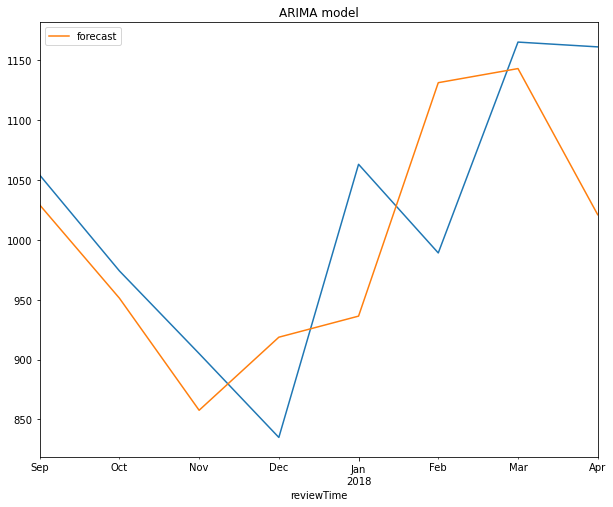

In [62]:
# plot the actual and forecast data of the test data
dfres3.actual.plot(figsize=(10,8))
dfres3.forecast.plot(legend=True)
plt.title("ARIMA model")

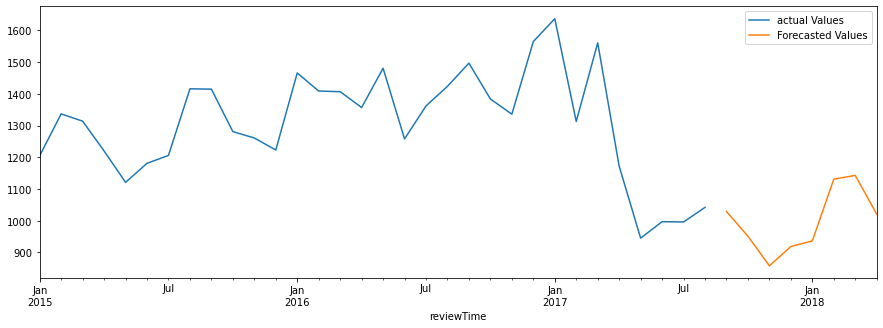

In [63]:
train3.plot(figsize=(15,5),label  = "actual Values")
dfres3.forecast.plot(label = "Forecasted Values")
plt.legend()
plt.show()

In [64]:
# make future predictions
n_steps = 12 # number of steps to forecast (2 years with monthly data)
start_index = len(neu_df) - 1
end_index = start_index + n_steps
future_predictions3 = m3.predict(start=start_index, end=end_index)
future_predictions3

2018-04-30    1020.928540
2018-05-31     984.255785
2018-06-30     961.636693
2018-07-31    1168.295717
2018-08-31    1103.400389
2018-09-30    1101.385502
2018-10-31    1047.645142
2018-11-30    1204.077172
2018-12-31     994.948155
2019-01-31    1075.700273
2019-02-28    1121.759625
2019-03-31    1193.138054
2019-04-30    1094.971958
Freq: M, Name: predicted_mean, dtype: float64

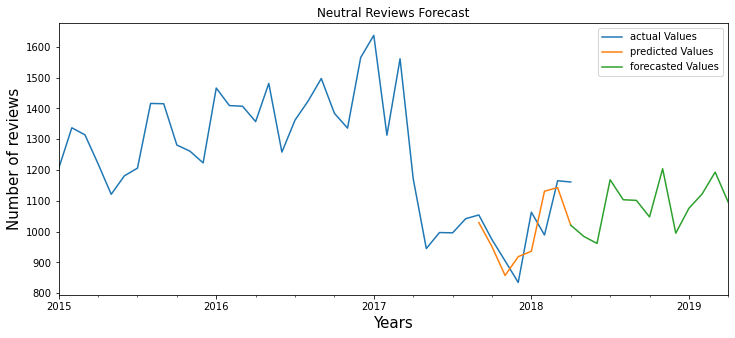

In [65]:
neu_df.plot(figsize=(12,5),label  = "actual Values")

dfres3.forecast.plot(figsize=(12,5),label  = "predicted Values")
future_predictions3.plot(figsize=(12,5),label  = "forecasted Values")

plt.title("Neutral Reviews Forecast")
plt.ylabel("Number of reviews", size = 15)

plt.xlabel("Years", size = 15)
plt.legend()
plt.show()


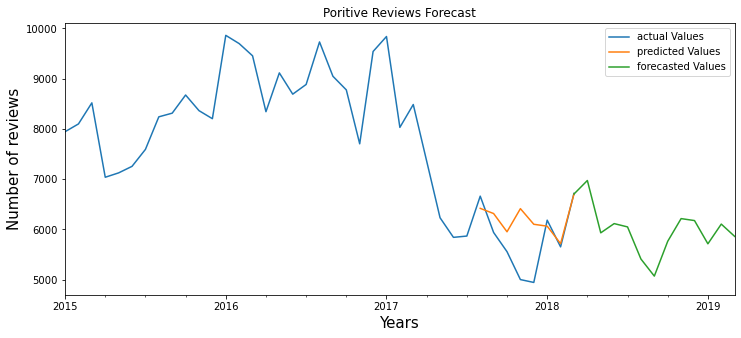

In [66]:

pos_df.plot(figsize=(12,5),label  = "actual Values")

dfres1.forecast.plot(figsize=(12,5),label  = "predicted Values")
future_predictions1.plot(figsize=(12,5),label  = "forecasted Values")

plt.title("Poritive Reviews Forecast")
plt.ylabel("Number of reviews", size = 15)

plt.xlabel("Years", size = 15)
plt.legend()


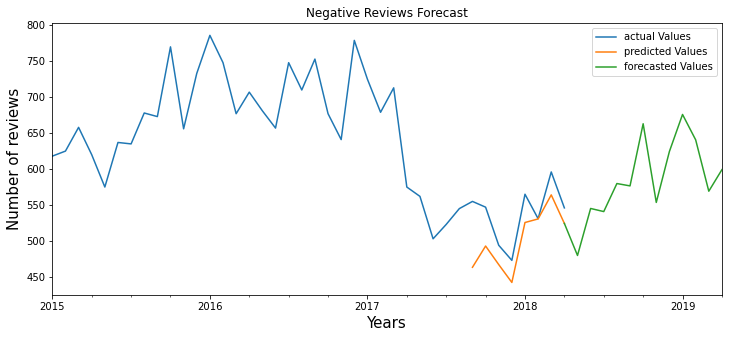

In [67]:
neg_df.plot(figsize=(12,5),label  = "actual Values")

dfres2.forecast.plot(figsize=(12,5),label  = "predicted Values")
future_predictions2.plot(figsize=(12,5),label  = "forecasted Values")

plt.title("Negative Reviews Forecast")
plt.ylabel("Number of reviews", size = 15)

plt.xlabel("Years", size = 15)
plt.legend()
